# Modeling for Football Data from Transfermarkt
- Kaggle Data URL

    - https://www.kaggle.com/datasets/davidcariboo/player-scores

## 데이터 설명
- Transfermarkt 웹사이트에서 스크레이핑한 각종 축구 데이터 (매주 한번 파일 업데이트)
    - 주요 대회 시즌별 60,000개 이상의 경기
    - 모든 대회의 400개 이상의 클럽들
    - 30,000 이상의 선수들
    - 400,000개 이상의 선수 가치 기록
    - 1,200,000개 이상의 선수 출전 기록

- `csv` 파일 설명
    - `apperances` : 선수 출장 기록
    - `club_games` : 클럽별 경기 홈팀, 어웨이팀 정보
    - `clubs` : 리그별 속해 있는 클럽
    - `competitions` : 대회 정보
    - `game_events` : 경기별 이벤트 정보 (카드, 득점, 어시스트 등)
    - `game_lineups` : 경기별 선수의 선발, 교체 명단 등재 여부
    - `games` : 경기에 대한 정보 (시즌, 라운드, 홈팀, 어웨이팀, 순위)
    - `player_valuations` : Transfermarkt 웹사이트에서 매긴 선수의 가치
    - `players` : 선수에 대한 세부 정보

- 데이터베이스 스키마
    <img src="https://raw.githubusercontent.com/dcaribou/transfermarkt-datasets/master/resources/diagram.svg?sanitize=true" width="1700">

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import optuna
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import RobustScaler

from xgboost import plot_importance

import shap

import warnings
warnings.filterwarnings(action='ignore')

In [68]:
# 데이터 경로
path = "data/df_eda.csv"
df = pd.read_csv(path)

In [69]:
df.head()

,player_name,start_season,goals,assists,minutes_played,competition_code,date_of_birth,age,position,current_club_name,market_value_per_season,country,foot,height_in_cm
0,Aaron Connolly,2019,3,2,1261,premier-league,2000-01-28,20,Centre-Forward,Brighton and Hove Albion Football Club,4000000.0,Ireland,right,174.0
1,Aaron Connolly,2020,2,1,791,premier-league,2000-01-28,21,Centre-Forward,Brighton and Hove Albion Football Club,7000000.0,Ireland,right,174.0
2,Aaron Connolly,2021,0,0,155,premier-league,2000-01-28,22,Centre-Forward,Brighton and Hove Albion Football Club,6000000.0,Ireland,right,174.0
3,Aaron Cresswell,2019,3,0,2730,premier-league,1989-12-15,30,Left-Back,West Ham United Football Club,6500000.0,England,left,170.0
4,Aaron Cresswell,2020,0,8,3172,premier-league,1989-12-15,31,Left-Back,West Ham United Football Club,5000000.0,England,left,170.0


In [70]:
# date_of_birth 열 제거 (age로 대체)
df = df.drop("date_of_birth", axis=1)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16001 entries, 0 to 16000
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player_name              16001 non-null  object 
 1   start_season             16001 non-null  int64  
 2   goals                    16001 non-null  int64  
 3   assists                  16001 non-null  int64  
 4   minutes_played           16001 non-null  int64  
 5   competition_code         16001 non-null  object 
 6   age                      16001 non-null  int64  
 7   position                 16001 non-null  object 
 8   current_club_name        16001 non-null  object 
 9   market_value_per_season  16001 non-null  float64
 10  country                  16001 non-null  object 
 11  foot                     16001 non-null  object 
 12  height_in_cm             16001 non-null  float64
dtypes: float64(2), int64(5), object(6)
memory usage: 1.6+ MB


In [72]:
# 수치형, 범주형 변수 따로 선언
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()

In [73]:
print("수치형 변수 :", num_cols)
print("범주형 변수 :", cat_cols)

수치형 변수 : ['start_season', 'goals', 'assists', 'minutes_played', 'age', 'market_value_per_season', 'height_in_cm']
범주형 변수 : ['player_name', 'competition_code', 'position', 'current_club_name', 'country', 'foot']


## 데이터 분리

In [74]:
# target 컬럼 "market_value_per_season"
target = "market_value_per_season"
# 나머지 컬럼 features에 선언
features = df.drop(columns=target).columns

# 학습할 train 데이터 : 19-20 ~ 22-23 시즌 데이터 (4시즌)
train = df[df.start_season != 2023]
# 예측할 test 데이터 : 23-24 시즌 데이터
test = df[df.start_season == 2023]

train.shape, test.shape

((13081, 13), (2920, 13))

In [75]:
# validation 데이터셋 생성
train, val = train_test_split(train, train_size=0.8, random_state=42)

In [76]:
# train 데이터 나눠준다
X_train = train[features]
y_train = train[target]

# validation 데이터 나눠준다
X_val = val[features]
y_val = val[target]

# test 데이터 나눠준다
X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((10464, 12), (10464,), (2617, 12), (2617,), (2920, 12), (2920,))

In [77]:
num_cols = df.drop(columns=target).select_dtypes(include=np.number).columns.tolist()

# train 데이터 copy
X_train_no_enc = train[features].copy()
# y_train_no_enc = train[target].copy()

# validation 데이터 copy
X_val_no_enc = val[features].copy()
# y_val_no_enc = val[target].copy()

# test 데이터 copy
X_test_no_enc = test[features].copy()
# y_test_no_enc = test[target].copy()

## 인코딩

### Target Encoding
- 머신 러닝 모델의 출력이 숫자 (회귀)일 때만 범주형 feature에 사용

- 각 범주에 대한 평균 목표값 계산 → 인코딩 하기 위해 범주형 값이 갖는 범주에 해당하는 백분율 대체
- 각 카테고리의 값을 학습 데이터의 target 값의 평균값으로 설정한다
- 데이터 관측치가 많아야 한다
- 과적합의 원인이 될 수 있다
- references
    - https://conanmoon.medium.com/%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B3%BC%ED%95%99-%EC%9C%A0%EB%A7%9D%EC%A3%BC%EC%9D%98-%EB%A7%A4%EC%9D%BC-%EA%B8%80%EC%93%B0%EA%B8%B0-%EC%9D%BC%EA%B3%B1%EB%B2%88%EC%A7%B8-%EC%9D%BC%EC%9A%94%EC%9D%BC-7a40e7de39d4
    - https://velog.io/@seungwoong12/encoding

In [78]:
# Scikit-learn TargetEncoder 사용
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html
# Scikit-learn 버전 높아야 사용 가능 (업데이트 필요)

# 범주형 변수 목록 cat_features에 선언
cat_features = df.select_dtypes(exclude=np.number).columns.tolist()

# smooth="auto", cv=5로 TargetEncoder 객체 생성
te = TargetEncoder(target_type="continuous", smooth="auto", cv=5)

for cat_feature in cat_features:
    # Train 데이터로 fit_transform 해준다
    X_train[[cat_feature]] = te.fit_transform(X_train[[cat_feature]], y_train)
    X_val[[cat_feature]] = te.transform(X_val[[cat_feature]])
    X_test[[cat_feature]] = te.transform(X_test[[cat_feature]])

## 회귀모델 평가 지표
- `R2 Score` (결정 계수)
    - 종속 변수의 총 변동 중 모델이 설명하는 변동의 비율
    - 0 ~ 1 사이의 값을 가지며, 높을 수록 모델이 데이터를 잘 설명한다는 뜻
    
- `RMSLE`
    - MSE에 루트를 씌운 RMSE의 각 인자에 로그를 취해준 값
        - 로그 변환을 통해 이상치에 대한 영향을 줄이고, 모델이 이상치에 대해 과도하게 페널티를 받지 않게 한다
        - 과소평가된 항목에 큰 패널티를 부여한다
        - 상대적 ERROR 측정
        - 값의 범위가 넓은 데이터에서 이상치에 대해 변화의 폭이 크지 않다
    - 정규 분포를 따르지 않고 불균형한 모형일 때 사용되는 방법

- 평가 지표 선정 이유
    - 예측하고자 하는 타겟에 이상치가 많이 존재한다 (`market_value_per_season`)
        - `R2 Score` : 모델이 얼마나 데이터의 변동을 잘 설명하는지 평가
        - `RMSLE` : 이상치에 강건한 특성을 갖는다
            - 실제보다 작게 예측이 되었을 때 페널티를 더 크게 부여한다
            - 선수 몸값이 실제 몸값 보다 적게 측정된다면, 
                - Transfermarkt 웹사이트가 몸값을 부풀린다고 오해받을 수 있다 
                - 실제 이적시장에 거품이 많이 끼어있다고 생각할 수도 있다
            - 따라서 과소 평가 항목에 페널티를 주는 `RMSLE`를 통해 평가

- References
    - https://shinminyong.tistory.com/32
    - https://wikidocs.net/219419
    - https://www.inflearn.com/questions/992421/rmsle%EC%9D%98-%EC%82%AC%EC%9A%A9%EC%97%90-%EA%B4%80%ED%95%9C-%EC%A7%88%EB%AC%B8%EC%9E%85%EB%8B%88%EB%8B%A4

In [79]:
def get_rmsle(y_actual, y_pred):
    # sklearn의 mean_square_log_error 함수는 y_pred 값 중 하나라도 0 미만인 경우 에러 발생
    # y_pred + 1 만들어 0보다 크게 만들어 준다 (음수가 되지 않게 방지)
    # 이후 optuna에 적용하여 RMSLE를 기준으로 하이퍼파라미터 튜닝
    
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()                 
    return np.sqrt(mean_error)   

In [80]:
# def rmsle(y, pred):
#     log_y = np.log1p(y)
#     log_pred = np.log1p(pred)
#     squared_error = (log_y-log_pred)**2
#     rmsle = np.sqrt(np.mean(squared_error))
#     return rmsle

## Baseline 모델 생성

In [81]:
# https://medium.com/machine-learning-with-python/multiple-linear-regression-implementation-in-python-2de9b303fc0c

In [82]:
# 선형회귀 모델로 Baseline 모델 생성
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [83]:
# Baseline 모델 절편, 결정 계수 확인

print("Intercept: ", lr.intercept_)
print("Coefficients:")
list(zip(X_train, lr.coef_))

Intercept:  399144413.2678441
Coefficients:


[('player_name', 0.6131487533421552),
 ('start_season', -201163.9100994235),
 ('goals', 718056.9250780508),
 ('assists', 566214.7797935513),
 ('minutes_played', 1730.8055397876067),
 ('competition_code', 0.18754003861249657),
 ('age', -267335.344174876),
 ('position', 0.10729894193536893),
 ('current_club_name', 0.38276716822292656),
 ('country', 0.011881600938068004),
 ('foot', 0.08060551992528531),
 ('height_in_cm', 33836.06787960629)]

In [84]:
def baseline_model(model_name, model):
    baseline_results = []

    print(f"\n====== Baseline Model : {model_name} ======")
    
    # 모델 생성 및 훈련
    # model.fit(X_train, y_train)

    # Baseline 모델로 train, validation, test 데이터셋 예측
    y_train_pred_lr = model.predict(X_train)
    y_val_pred_lr = model.predict(X_val)
    y_test_pred_lr = model.predict(X_test)

    # Baseline 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
    base_meanAbErr = metrics.mean_absolute_error(y_test, y_test_pred_lr)
    base_meanSqErr = metrics.mean_squared_error(y_test, y_test_pred_lr)
    base_rootMeanSqErr = metrics.mean_squared_error(y_test, y_test_pred_lr, squared=False)
    base_rootMeanSqLogErr = get_rmsle(y_test, y_test_pred_lr)


    # 결과를 리스트에 저장
    baseline_results.append({"Model" : model_name,
                             "MAE" : '{:.2f}'.format(base_meanAbErr),
                             "MSE" : '{:.2f}'.format(base_meanSqErr),
                             "RMSE" : '{:.2f}'.format(base_rootMeanSqErr),
                             "RMSLE" : '{:.2f}'.format(base_rootMeanSqLogErr),
                             "R2 Score" : '{:.2f}'.format(model.score(X_test, y_test))})
    
    # 결과 리스트를 DataFrame으로 변환
    baseline_df = pd.DataFrame(baseline_results)
    
    return baseline_df

In [19]:
baseline_model("Linear Regression", lr)


====== Baseline Model : Linear Regression ======


,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,Linear Regression,5370699.97,95439593320733.36,9769318.98,0.97,0.65


## 스케일링
- 데이터셋의 다양한 컬럼들에 이상치 다수 존재
    - 하지만 축구라는 스포츠의 특성 상, 득점, 도움, 시장 가치 등 몇몇의 특출난 선수들의 스탯이 도드라진다
    - 따라서 이상치 제거하지 않음
- `RobustScaler` 선택 (이상치의 영향 최소화)
- References
    - https://cheris8.github.io/data%20analysis/DP-Data-Scaling/

### `RobustScaling`
- 데이터의 중앙값 = 0, IQE = 1이 되도록 스케일링
    - IQR = Q3 - Q1 : 25퍼센타일과 75퍼센타일의 값들
- 중앙값 (Median)과 IQR (Interquartile Range) 사용
    - `RobustScaler`를 사용할 경우, `StandardScaler`에 비해 스케일링 결과가 더 넓게 분포
- 모든 feature들이 같은 스케일을 갖는다
- 이상치의 영향을 최소화 한다

In [85]:
# RobustScaler X_train 데이터셋에 fit
robustScaler = RobustScaler().fit(X_train)

# RobustScaler로 X_train, X_val, X_test 데이터셋 변환
X_train_robust = robustScaler.transform(X_train)
X_val_robust = robustScaler.transform(X_val)
X_test_robust = robustScaler.transform(X_test)

## 머신러닝 모델링

### 하이퍼 파라미터 튜닝 전 모델 생성

In [86]:
model_list = ["lr_model", "dt_model", "rf_model", "cat_model", "lgbm_model", "xgb_model"]

lr_model = LinearRegression()
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
cat_model = CatBoostRegressor(random_state=42)
lgbm_model = LGBMRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)

In [87]:
models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("CatBoost", CatBoostRegressor(random_state=42)),
    ("LightGBM", LGBMRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42))
]

In [88]:
def model_list(models, when="Before"):
    models_results = []

    for model_name, model in models:

        # 모델 생성 및 훈련
        model.fit(X_train_robust, y_train)

        # Robust Scaling 거친 train 데이터를 바탕으로 예측
        y_train_pred = model.predict(X_train_robust)
        y_val_pred = model.predict(X_val_robust)
        y_test_pred = model.predict(X_test_robust)

        # 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
        meanAbErr = metrics.mean_absolute_error(y_test, y_test_pred)
        meanSqErr = metrics.mean_squared_error(y_test, y_test_pred)
        rootMeanSqErr = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
        rootMeanSqLogErr = get_rmsle(y_test, y_test_pred)


        # 결과를 리스트에 저장
        models_results.append({"Model" : model_name,
                                "MAE" : '{:.2f}'.format(meanAbErr),
                                "MSE" : '{:.2f}'.format(meanSqErr),
                                "RMSE" : '{:.2f}'.format(rootMeanSqErr),
                                "RMSLE" : '{:.2f}'.format(rootMeanSqLogErr),
                                "R2 Score" : '{:.2f}'.format(model.score(X_test_robust, y_test))})
    
    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n====== Models {when} Hyper Parameter Tuning ======")
    
    return models_df.sort_values(by=["RMSLE", "R2 Score"], ascending=[True, False]).reset_index(drop=True)

In [89]:
# Top 3 : Random Forest, LightGBM, CatBoost, XGBoost순으로 RMSLE 높다
model_list(models)

Learning rate set to 0.059332
0:	learn: 13547345.9112449	total: 3.17ms	remaining: 3.16s
1:	learn: 13067302.1797187	total: 5.61ms	remaining: 2.8s
2:	learn: 12610340.0672112	total: 8.01ms	remaining: 2.66s
3:	learn: 12182225.5521943	total: 10.7ms	remaining: 2.66s
4:	learn: 11807297.0050161	total: 13.7ms	remaining: 2.72s
5:	learn: 11417954.2888149	total: 16.7ms	remaining: 2.76s
6:	learn: 11084575.8853794	total: 19.4ms	remaining: 2.75s
7:	learn: 10769719.9427783	total: 22.1ms	remaining: 2.74s
8:	learn: 10446331.4582456	total: 24.9ms	remaining: 2.74s
9:	learn: 10178015.9808002	total: 27.5ms	remaining: 2.72s
10:	learn: 9923764.1166994	total: 30.7ms	remaining: 2.76s
11:	learn: 9681007.4833589	total: 33.4ms	remaining: 2.75s
12:	learn: 9429742.3387788	total: 35.8ms	remaining: 2.71s
13:	learn: 9214044.7202939	total: 38.1ms	remaining: 2.68s
14:	learn: 9021788.1848989	total: 40.4ms	remaining: 2.65s
15:	learn: 8842834.8587452	total: 43.2ms	remaining: 2.66s
16:	learn: 8680582.1975046	total: 46ms	rema

,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,Random Forest,4248991.70,85433723807726.88,9243036.50,0.65,0.69
1,LightGBM,4084505.14,75259488954124.56,8675222.70,0.69,0.72
2,CatBoost,3967694.69,68492414811917.24,8276014.43,0.73,0.75
3,XGBoost,4285748.65,79190661499302.77,8898913.50,0.77,0.71
4,Decision Tree,5390308.22,124216992722602.73,11145267.73,0.92,0.54
5,Linear Regression,5389966.25,94732960933571.91,9733085.89,0.98,0.65


In [93]:
# 범주형 변수를 따로 Target Encoding 거치지 않은 데이터셋으로 학습한 CatBoost 확인
def model_list2(models):
    models_results = []

    for model_name, model in models:

        if model_name == "CatBoost":

            cat_features = X_train_no_enc.select_dtypes(exclude=np.number).columns.tolist()

            # 모델 생성 및 훈련
            model.fit(X_train_no_enc, y_train, cat_features=cat_features)

            # Robust Scaling 거치지 않은 train 데이터를 바탕으로 예측
            y_train_pred_cat = model.predict(X_train_no_enc)
            y_val_pred_cat = model.predict(X_val_no_enc)
            y_test_pred_cat = model.predict(X_test_no_enc)

            # 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
            meanAbErr_cat = metrics.mean_absolute_error(y_test, y_test_pred_cat)
            meanSqErr_cat = metrics.mean_squared_error(y_test, y_test_pred_cat)
            rootMeanSqErr_cat = metrics.mean_squared_error(y_test, y_test_pred_cat, squared=False)
            rootMeanSqLogErr_cat = get_rmsle(y_test, y_test_pred_cat)

            # 결과를 리스트에 저장
            models_results.append({"Model" : model_name,
                                    "MAE" : '{:.2f}'.format(meanAbErr_cat),
                                    "MSE" : '{:.2f}'.format(meanSqErr_cat),
                                    "RMSE" : '{:.2f}'.format(rootMeanSqErr_cat),
                                    "RMSLE" : '{:.2f}'.format(rootMeanSqLogErr_cat),
                                    "R2 Score" : '{:.2f}'.format(model.score(X_test_no_enc, y_test))})
        
        else:
            
            # 모델 생성 및 훈련
            model.fit(X_train, y_train)

            # Robust Scaling 거친 train 데이터를 바탕으로 예측
            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)
            y_test_pred = model.predict(X_test)

            # 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
            meanAbErr = metrics.mean_absolute_error(y_test, y_test_pred)
            meanSqErr = metrics.mean_squared_error(y_test, y_test_pred)
            rootMeanSqErr = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
            rootMeanSqLogErr = get_rmsle(y_test, y_test_pred)


            # 결과를 리스트에 저장
            models_results.append({"Model" : model_name,
                                    "MAE" : '{:.2f}'.format(meanAbErr),
                                    "MSE" : '{:.2f}'.format(meanSqErr),
                                    "RMSE" : '{:.2f}'.format(rootMeanSqErr),
                                    "RMSLE" : '{:.2f}'.format(rootMeanSqLogErr),
                                    "R2 Score" : '{:.2f}'.format(model.score(X_test, y_test))})
    
    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n====== Models before Hyper Parameter Tuning ======")
    
    return models_df.sort_values(by=["RMSLE", "R2 Score"], ascending=[True, False]).reset_index(drop=True)

In [94]:
model_list2(models)

Learning rate set to 0.059332
0:	learn: 13653696.6051392	total: 65.4ms	remaining: 1m 5s
1:	learn: 13289911.9578542	total: 143ms	remaining: 1m 11s
2:	learn: 12974497.2540124	total: 232ms	remaining: 1m 17s
3:	learn: 12664524.7075041	total: 309ms	remaining: 1m 17s
4:	learn: 12381771.8118006	total: 391ms	remaining: 1m 17s
5:	learn: 12110808.3301324	total: 462ms	remaining: 1m 16s
6:	learn: 11857426.9500235	total: 536ms	remaining: 1m 16s
7:	learn: 11614183.0093664	total: 608ms	remaining: 1m 15s
8:	learn: 11410700.5592546	total: 681ms	remaining: 1m 15s
9:	learn: 11187253.5307023	total: 757ms	remaining: 1m 14s
10:	learn: 10977126.3796601	total: 829ms	remaining: 1m 14s
11:	learn: 10794053.4259314	total: 905ms	remaining: 1m 14s
12:	learn: 10632607.2516437	total: 987ms	remaining: 1m 14s
13:	learn: 10463427.2507392	total: 1.14s	remaining: 1m 20s
14:	learn: 10314079.3497962	total: 1.25s	remaining: 1m 22s
15:	learn: 10166125.8591156	total: 1.32s	remaining: 1m 21s
16:	learn: 10041279.0114318	total: 1

,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,Random Forest,4245153.85,85158391550535.09,9228130.45,0.65,0.69
1,LightGBM,4084003.49,74950229256618.64,8657380.05,0.70,0.72
2,XGBoost,4284056.73,79153125624359.34,8896804.24,0.77,0.71
3,CatBoost,4599038.41,85747317567412.42,9259984.75,0.84,0.68
4,Decision Tree,5394486.30,124283444777397.27,11148248.51,0.92,0.54
5,Linear Regression,5389966.25,94732960936294.64,9733085.89,0.98,0.65


#### `CatBoost` 성능 비교
- 별도로 `Target Encoding` 거친 데이터셋으로 진행(`model_list` 함수)한 `CatBoost`가 더 낮은 `RMSLE` 기록

    - **0.73 vs 0.84** (Target Encoding 실행한 데이터셋으로 진행)

### 하이퍼 파라미터 튜닝
- `RMSLE`가 높은 `Random Forest`, `CatBoost`, `LightGBM`, `XGBoost` 을 갖고 하이퍼 파라미터 튜닝
    - Baseline 모델인 `Linear Regression`의 `RMSLE`보다 낮다 (0.98)

- `optuna` 활용
    - References : https://forecastegy.com/posts/xgboost-hyperparameter-tuning-with-optuna/


In [95]:
# optuna sampling seed 고정
sampler = TPESampler(seed=42)

#### `Random Forest`

In [106]:
def objective_rf(trial):
    params = {
        # "iterations": 1000,
        "n_estimators" : trial.suggest_int('n_estimators', 500, 4000),
        # "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "max_samples": trial.suggest_float("max_samples", 0.05, 1.0),
        "max_features": trial.suggest_float("max_features", 0.05, 1.0),
        "min_weight_fraction_leaf": trial.suggest_int("min_weight_fraction_leaf", 0.05, 0.5),
    }

    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train_robust, y_train)
    predictions = model.predict(X_test_robust)
    rmsle = get_rmsle(y_test, predictions)

    return rmsle

In [108]:
study_rf = optuna.create_study(direction='minimize', sampler=sampler)
study_rf.optimize(objective_rf, n_trials=30)

[I 2024-04-03 11:30:55,967] A new study created in memory with name: no-name-4f600e26-43fb-473b-bbb0-5a8d38e45e78
[I 2024-04-03 11:31:03,453] Trial 0 finished with value: 0.8247418189938397 and parameters: {'n_estimators': 2593, 'max_depth': 10, 'max_samples': 0.13406787694932354, 'max_features': 0.23618371929818793, 'min_weight_fraction_leaf': 0}. Best is trial 0 with value: 0.8247418189938397.
[I 2024-04-03 11:31:05,558] Trial 1 finished with value: 1.0516914769531576 and parameters: {'n_estimators': 658, 'max_depth': 4, 'max_samples': 0.4192434252050079, 'max_features': 0.3077815801852011, 'min_weight_fraction_leaf': 0}. Best is trial 0 with value: 0.8247418189938397.
[I 2024-04-03 11:31:19,242] Trial 2 finished with value: 0.9928834832188229 and parameters: {'n_estimators': 3401, 'max_depth': 4, 'max_samples': 0.3168877842030117, 'max_features': 0.565561279000336, 'min_weight_fraction_leaf': 0}. Best is trial 0 with value: 0.8247418189938397.
[I 2024-04-03 11:31:25,821] Trial 3 fin

In [109]:
print("Best hyperparameters:", study_rf.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSLE:", study_rf.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 877, 'max_depth': 10, 'max_samples': 0.6775692835370353, 'max_features': 0.8852897876045895, 'min_weight_fraction_leaf': 0}
-----------------------------------------------------------------------------------------------------------------
Best RMSLE:
0.6994136813434099


In [110]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_rf)

In [111]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_rf)

In [112]:
rf_optuna = RandomForestRegressor(**study_rf.best_params)
model_list([("RandomForest_tuned", rf_optuna)], "After")


====== Models Before Hyper Parameter Tuning ======


,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,RandomForest_tuned,4379679.70,88350604837292.34,9399500.24,0.70,0.67


#### `CatBoost`

In [28]:
def objective_cat(trial):
    params = {
        # "iterations": 1000,
        "iterations" : trial.suggest_int('n_estimators', 500, 4000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = CatBoostRegressor(**params, silent=True, random_state=42)
    model.fit(X_train_robust, y_train)
    predictions = model.predict(X_test_robust)
    rmsle = get_rmsle(y_test, predictions)

    return rmsle

In [29]:
study_cat = optuna.create_study(direction='minimize', sampler=sampler)
study_cat.optimize(objective_cat, n_trials=30)

[I 2024-04-03 10:21:29,981] A new study created in memory with name: no-name-6670bd9c-87db-4501-b47b-5e35c0976666
[I 2024-04-03 10:21:35,808] Trial 0 finished with value: 0.7394622345764149 and parameters: {'n_estimators': 1811, 'learning_rate': 0.07969454818643935, 'depth': 8, 'subsample': 0.6187255599871848, 'colsample_bylevel': 0.19821770842031466, 'min_data_in_leaf': 16}. Best is trial 0 with value: 0.7394622345764149.
[I 2024-04-03 10:21:36,888] Trial 1 finished with value: 0.8526873775520201 and parameters: {'n_estimators': 703, 'learning_rate': 0.05399484409787434, 'depth': 7, 'subsample': 0.7226689489062432, 'colsample_bylevel': 0.06955526958101232, 'min_data_in_leaf': 97}. Best is trial 0 with value: 0.7394622345764149.
[I 2024-04-03 10:21:40,769] Trial 2 finished with value: 0.8268488787771944 and parameters: {'n_estimators': 3414, 'learning_rate': 0.0026587543983272706, 'depth': 2, 'subsample': 0.22423428436076215, 'colsample_bylevel': 0.3390301308115608, 'min_data_in_leaf':

In [30]:
print("Best hyperparameters:", study_cat.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSLE:", study_cat.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 3908, 'learning_rate': 0.011782800596762835, 'depth': 10, 'subsample': 0.9718768816360378, 'colsample_bylevel': 0.7053959021822074, 'min_data_in_leaf': 74}
-----------------------------------------------------------------------------------------------------------------
Best RMSLE:
0.6460891260840952


In [31]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_cat)

In [32]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_cat)

In [33]:
cat_optuna = CatBoostRegressor(**study_cat.best_params)
model_list([("CatBoost_tuned", cat_optuna)], "After")

0:	learn: 13944882.5086415	total: 15.1ms	remaining: 58.9s
1:	learn: 13853773.6043544	total: 27.8ms	remaining: 54.3s
2:	learn: 13747032.8466324	total: 40.5ms	remaining: 52.7s
3:	learn: 13641956.4600407	total: 52ms	remaining: 50.8s
4:	learn: 13539329.9496173	total: 66.5ms	remaining: 51.9s
5:	learn: 13449295.7770281	total: 77.4ms	remaining: 50.3s
6:	learn: 13349301.1465529	total: 89.7ms	remaining: 50s
7:	learn: 13252668.3190848	total: 102ms	remaining: 49.5s
8:	learn: 13157506.8977730	total: 113ms	remaining: 49.1s
9:	learn: 13062875.3222875	total: 129ms	remaining: 50.2s
10:	learn: 12972032.0571845	total: 141ms	remaining: 50s
11:	learn: 12885557.4745263	total: 154ms	remaining: 50s
12:	learn: 12796434.4696744	total: 167ms	remaining: 50.2s
13:	learn: 12706031.6686251	total: 179ms	remaining: 49.9s
14:	learn: 12616659.1707317	total: 192ms	remaining: 49.7s
15:	learn: 12536818.6697601	total: 204ms	remaining: 49.6s
16:	learn: 12453416.1099258	total: 218ms	remaining: 49.8s
17:	learn: 12378071.04130

327:	learn: 5296831.7469615	total: 4.5s	remaining: 49.1s
328:	learn: 5292174.3968030	total: 4.52s	remaining: 49.1s
329:	learn: 5288458.9495070	total: 4.53s	remaining: 49.1s
330:	learn: 5284681.1786933	total: 4.54s	remaining: 49.1s
331:	learn: 5279892.0488793	total: 4.55s	remaining: 49s
332:	learn: 5274903.0373890	total: 4.57s	remaining: 49s
333:	learn: 5271859.2825584	total: 4.58s	remaining: 49s
334:	learn: 5267437.0843483	total: 4.59s	remaining: 49s
335:	learn: 5264338.9779848	total: 4.61s	remaining: 49s
336:	learn: 5259340.0150601	total: 4.62s	remaining: 49s
337:	learn: 5255162.0310855	total: 4.63s	remaining: 48.9s
338:	learn: 5250691.3375265	total: 4.64s	remaining: 48.9s
339:	learn: 5245563.2698091	total: 4.66s	remaining: 48.9s
340:	learn: 5242094.8465300	total: 4.67s	remaining: 48.9s
341:	learn: 5236852.3689653	total: 4.69s	remaining: 48.9s
342:	learn: 5232845.5626508	total: 4.7s	remaining: 48.9s
343:	learn: 5228608.3549288	total: 4.76s	remaining: 49.4s
344:	learn: 5224751.7860092	

,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,CatBoost_tuned,3951012.85,74477892878551.17,8630057.52,0.64,0.73


#### `XGBoost`

In [34]:
def objective_xgb(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators" : trial.suggest_int('n_estimators', 500, 4000),
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train_robust, y_train, verbose=False)
    predictions = model.predict(X_test_robust)
    rmsle = get_rmsle(y_test, predictions)

    return rmsle

In [35]:
study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb.optimize(objective_xgb, n_trials=30)

[I 2024-04-03 10:32:21,716] A new study created in memory with name: no-name-972dee94-3f93-4601-a375-96267a508f46


[I 2024-04-03 10:32:28,509] Trial 0 finished with value: 0.796884630666854 and parameters: {'n_estimators': 1860, 'learning_rate': 0.003488976654890368, 'max_depth': 9, 'subsample': 0.3889156603589098, 'colsample_bytree': 0.3168877842030117, 'min_child_weight': 11}. Best is trial 0 with value: 0.796884630666854.
[I 2024-04-03 10:32:29,280] Trial 1 finished with value: 0.8723423699027717 and parameters: {'n_estimators': 993, 'learning_rate': 0.040215545266902894, 'max_depth': 1, 'subsample': 0.9875425897704915, 'colsample_bytree': 0.7836325308318246, 'min_child_weight': 4}. Best is trial 0 with value: 0.796884630666854.
[I 2024-04-03 10:32:31,520] Trial 2 finished with value: 0.6690545769678158 and parameters: {'n_estimators': 519, 'learning_rate': 0.04274869455295218, 'max_depth': 8, 'subsample': 0.742556809638938, 'colsample_bytree': 0.7827068293516485, 'min_child_weight': 2}. Best is trial 2 with value: 0.6690545769678158.
[I 2024-04-03 10:32:38,441] Trial 3 finished with value: 0.73

In [36]:
print("Best hyperparameters:", study_xgb.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSLE:", study_xgb.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 1020, 'learning_rate': 0.008291697333477399, 'max_depth': 9, 'subsample': 0.5932298910332178, 'colsample_bytree': 0.997946107446805, 'min_child_weight': 5}
-----------------------------------------------------------------------------------------------------------------
Best RMSLE:
0.6318878922229489


In [37]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_xgb)

In [38]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_xgb)

In [39]:
xgb_optuna = XGBRegressor(**study_xgb.best_params)
model_list([("XGBoost_tuned", xgb_optuna)], "After")


====== Models Before Hyper Parameter Tuning ======


,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,XGBoost_tuned,3992192.88,74220695019160.98,8615143.35,0.64,0.73


#### `LightGBM`

In [40]:
def objective_lgbm(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators": trial.suggest_int('n_estimators', 500, 4000),
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = LGBMRegressor(**params, random_state=42)
    model.fit(X_train_robust, y_train)
    predictions = model.predict(X_test_robust)
    rmsle = get_rmsle(y_test, predictions)


    return rmsle

In [41]:
study_lgbm = optuna.create_study(direction='minimize', sampler=sampler)
study_lgbm.optimize(objective_lgbm, n_trials=30)

[I 2024-04-03 10:35:22,625] A new study created in memory with name: no-name-6978118d-c700-460f-85eb-701750ac4099


[I 2024-04-03 10:35:25,856] Trial 0 finished with value: 0.9798792068762626 and parameters: {'n_estimators': 3326, 'learning_rate': 0.06197015748809146, 'num_leaves': 327, 'subsample': 0.15454932830129292, 'colsample_bytree': 0.2665384044148446, 'min_data_in_leaf': 43}. Best is trial 0 with value: 0.9798792068762626.
[I 2024-04-03 10:35:27,240] Trial 1 finished with value: 0.7906449978852679 and parameters: {'n_estimators': 3363, 'learning_rate': 0.05265761277157429, 'num_leaves': 9, 'subsample': 0.5352099374486874, 'colsample_bytree': 0.44654045299134, 'min_data_in_leaf': 23}. Best is trial 1 with value: 0.7906449978852679.
[I 2024-04-03 10:35:28,397] Trial 2 finished with value: 0.6757327329021408 and parameters: {'n_estimators': 919, 'learning_rate': 0.0047340227734041914, 'num_leaves': 966, 'subsample': 0.35704278541971746, 'colsample_bytree': 0.5428510906561977, 'min_data_in_leaf': 71}. Best is trial 2 with value: 0.6757327329021408.
[I 2024-04-03 10:35:31,802] Trial 3 finished wi

In [42]:
print("Best hyperparameters:", study_lgbm.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSLE:", study_lgbm.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 3709, 'learning_rate': 0.0016461757905594462, 'num_leaves': 908, 'subsample': 0.40512457709114685, 'colsample_bytree': 0.9777247352386009, 'min_data_in_leaf': 5}
-----------------------------------------------------------------------------------------------------------------
Best RMSLE:
0.6208168583222964


In [43]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_lgbm)

In [44]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_lgbm)

In [45]:
lgbm_optuna = LGBMRegressor(**study_lgbm.best_params)
model_list([("LightGBM_tuned", lgbm_optuna)], "After")

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1231
[LightGBM] [Info] Number of data points in the train set: 10464, number of used features: 12
[LightGBM] [Info] Start training from score 8983092.029817


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5

====== Models Before Hyper Parameter Tuning ======


,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,LightGBM_tuned,4277580.27,84661268880832.95,9201155.84,0.66,0.69


#### 튜닝한 모델들 비교

In [113]:
models_tuned = models = [
    ("RandomForest_tuned", rf_optuna),
    ("CatBoost_tuned", cat_optuna),
    ("LightGBM_tuned", lgbm_optuna),
    ("XGBoost_tuned", xgb_optuna)
]

In [114]:
model_list(models_tuned, "After")

0:	learn: 13946632.7791189	total: 15.6ms	remaining: 1m
1:	learn: 13846874.6242859	total: 31.5ms	remaining: 1m 1s
2:	learn: 13745177.8629015	total: 45.2ms	remaining: 58.9s
3:	learn: 13639288.0864986	total: 58.6ms	remaining: 57.2s
4:	learn: 13532745.1151256	total: 72ms	remaining: 56.2s
5:	learn: 13437005.1159221	total: 84.2ms	remaining: 54.7s
6:	learn: 13336658.2813260	total: 97.5ms	remaining: 54.3s
7:	learn: 13237564.7795240	total: 111ms	remaining: 54.1s
8:	learn: 13145381.6771679	total: 124ms	remaining: 53.9s
9:	learn: 13049863.9426483	total: 139ms	remaining: 54.1s
10:	learn: 12962614.7844721	total: 153ms	remaining: 54.1s
11:	learn: 12870690.1397910	total: 167ms	remaining: 54.3s
12:	learn: 12779196.4774276	total: 182ms	remaining: 54.6s
13:	learn: 12687864.1902909	total: 197ms	remaining: 54.7s
14:	learn: 12598310.1350555	total: 210ms	remaining: 54.5s
15:	learn: 12517907.7087080	total: 224ms	remaining: 54.4s
16:	learn: 12432970.6878451	total: 239ms	remaining: 54.7s
17:	learn: 12354324.74

,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,XGBoost_tuned,4002053.08,74831914637416.11,8650544.18,0.63,0.72
1,LightGBM_tuned,4228526.88,82324307252914.83,9073274.34,0.64,0.70
2,CatBoost_tuned,3970216.83,75012066766542.28,8660950.68,0.65,0.72
3,RandomForest_tuned,4368572.99,87331683235870.70,9345142.23,0.70,0.68


##### 모델별 최적의 하이퍼파라미터

In [48]:
best_params_rf = {'n_estimators': 877, 
                  'max_depth': 10, 
                  'max_samples': 0.6775692835370353, 
                  'max_features': 0.8852897876045895, 
                  'min_weight_fraction_leaf': 0}

best_params_cat = {'n_estimators': 2907, 
                   'learning_rate': 0.016427182662370712, 
                   'depth': 9, 
                   'subsample': 0.34619574575079914, 
                   'colsample_bylevel': 0.4812914285399674, 
                   'min_data_in_leaf': 90}

best_params_xgb = {'n_estimators': 918, 
                   'learning_rate': 0.006077484069934721, 
                   'max_depth': 10, 
                   'subsample': 0.8949424915076419, 
                   'colsample_bytree': 0.8373294951864462, 
                   'min_child_weight': 5}

best_params_lgbm = {'n_estimators': 3560, 
                    'learning_rate': 0.0013674611103915398, 
                    'num_leaves': 920, 
                    'subsample': 0.5700770391865846, 
                    'colsample_bytree': 0.8933043311096593, 
                    'min_data_in_leaf': 35}

### 최적화 후 모델 재생성

In [119]:

# Robust 스케일링 적용한 X_train_scaled 이용
xgb_optuna.fit(X_train_robust, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.997946107446805, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.008291697333477399,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=1020, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

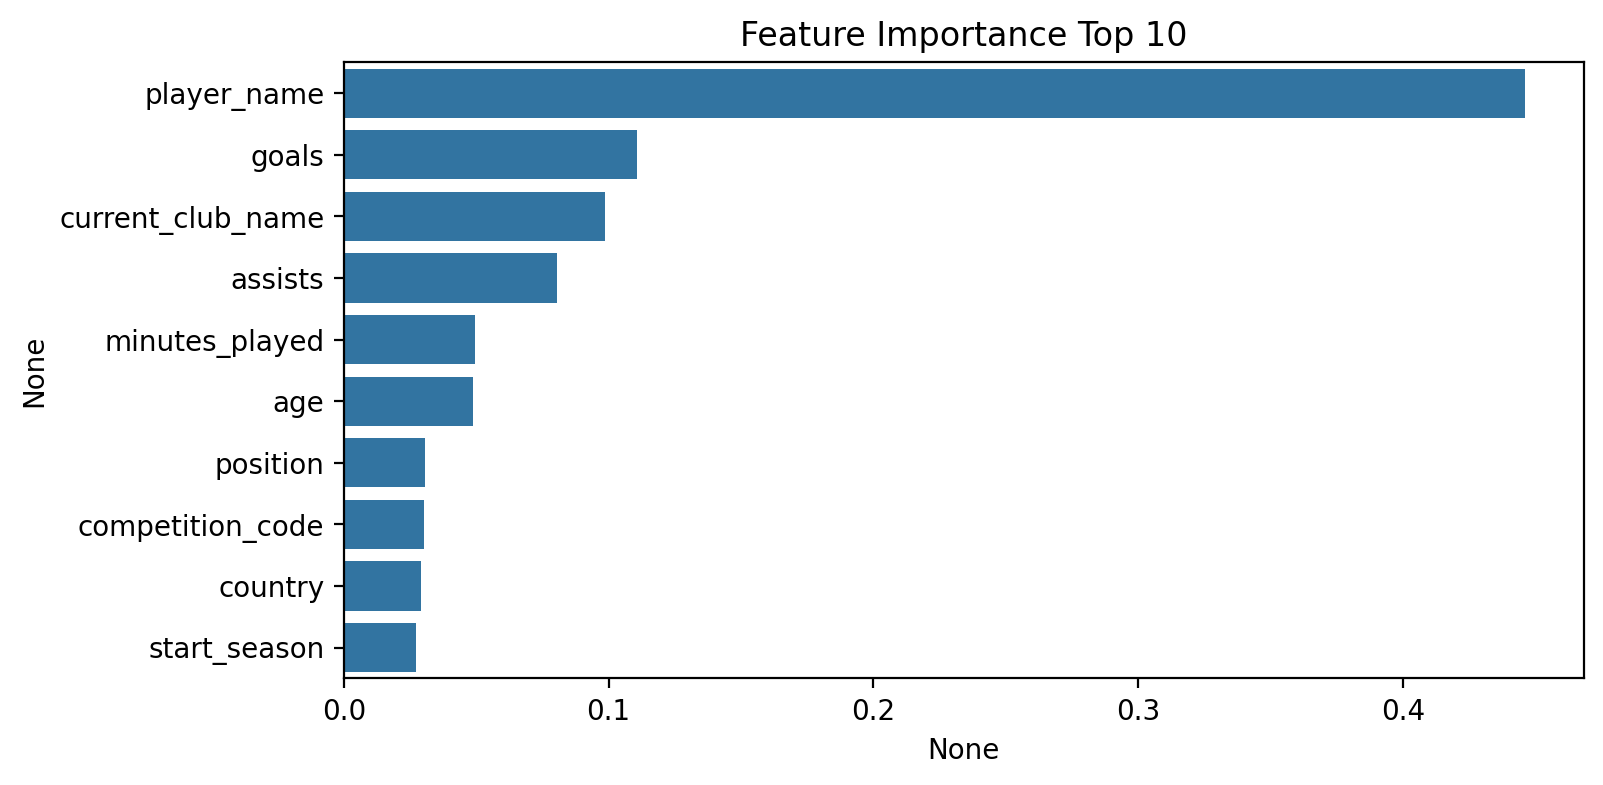

In [121]:
# feature importance 파악

# 배열형태로 반환
xgb_importance_values = xgb_optuna.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
xgb_series = pd.Series(xgb_importance_values, index = X_train.columns)
xgb_top10 = xgb_series.sort_values(ascending=False)[:10]

# 시각화
plt.figure(figsize=(8,4))
plt.title('Feature Importance Top 10')
sns.barplot(x=xgb_top10, y=xgb_top10.index)
plt.show()


# 이 지표는 절대적이지 않다.
# 중요도는 낮게 평가되었지만 실제로 중요한 특성일 수도 있고,
# 그렇기 때문에 제거했을 경우 성능이 떨어질 수도 있다.
# -> 상위 n개의 특성들을 제외한 나머지 특성들을 모두 제거하는 방식은 바람직하지 못함

# feature importance를 고려하여 특성별로 A/B test 를 진행하며 feature selection 해야 한다
# https://hwi-doc.tistory.com/entry/Feature-selection-feature-importance-vs-permutation-importance

In [57]:
y_test

7          900000.0
11       30000000.0
21       28000000.0
26       15000000.0
27         500000.0
            ...    
15983     5000000.0
15988     1800000.0
15994     1000000.0
15995     1000000.0
16000    18000000.0
Name: market_value_per_season, Length: 2920, dtype: float64

In [58]:
X_test

,player_name,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
7,3.090621e+06,2023,0,0,235,1.760686e+07,34,7.573533e+06,1.669718e+07,1.580558e+07,9.059222e+06,170.0
11,1.378455e+07,2023,0,0,720,1.760686e+07,21,6.410489e+06,1.246267e+07,1.165922e+07,8.371419e+06,185.0
21,1.869467e+07,2023,0,0,540,1.760686e+07,25,5.777534e+06,3.253681e+07,1.580558e+07,8.982164e+06,190.0
26,6.612677e+06,2023,0,0,526,1.760686e+07,21,1.040246e+07,4.469679e+06,1.580558e+07,8.982164e+06,181.0
27,8.983092e+06,2023,1,0,298,9.004052e+06,28,9.240542e+06,1.740985e+06,8.238751e+06,9.059222e+06,199.0
...,...,...,...,...,...,...,...,...,...,...,...,...
15983,4.012582e+06,2023,1,0,2093,9.404664e+06,29,9.814288e+06,3.976935e+06,7.964127e+06,8.982164e+06,177.0
15988,2.202918e+06,2023,1,4,1664,9.404664e+06,34,6.410489e+06,8.704671e+06,7.964127e+06,8.982164e+06,182.0
15994,9.018411e+05,2023,0,0,1170,9.404664e+06,33,5.777534e+06,1.168214e+07,1.263018e+07,8.982164e+06,192.0
15995,8.983092e+06,2023,1,0,366,2.712768e+06,22,1.059005e+07,9.386958e+05,6.922201e+06,9.059222e+06,170.0


In [62]:
df[df.player_name=="Kai Havertz"]

,player_name,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,market_value_per_season,country,foot,height_in_cm
7838,Kai Havertz,2019,12,6,2463,bundesliga,20,Attacking Midfield,Arsenal Football Club,81000000.0,Germany,left,193.0
7839,Kai Havertz,2020,4,5,1520,premier-league,21,Attacking Midfield,Arsenal Football Club,70000000.0,Germany,left,193.0
7840,Kai Havertz,2021,8,4,1811,premier-league,22,Attacking Midfield,Arsenal Football Club,70000000.0,Germany,left,193.0
7841,Kai Havertz,2022,7,1,2579,premier-league,23,Attacking Midfield,Arsenal Football Club,55000000.0,Germany,left,193.0
7842,Kai Havertz,2023,8,3,1783,premier-league,24,Attacking Midfield,Arsenal Football Club,55000000.0,Germany,left,193.0


In [63]:
test[features][test[features].player_name=="Kai Havertz"]

,player_name,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
7842,Kai Havertz,2023,8,3,1783,premier-league,24,Attacking Midfield,Arsenal Football Club,Germany,left,193.0


In [124]:
y_test.reset_index()[y_test.reset_index()["index"]==7842]

,index,market_value_per_season
1446,7842,55000000.0


In [123]:
# 1446
# Kai Havertz
xgb_optuna.predict(X_test_robust)[1446]

67129590.0

In [125]:
df[df.player_name=="Heung-min Son"]

,player_name,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,market_value_per_season,country,foot,height_in_cm
5729,Heung-min Son,2019,11,11,2488,premier-league,27,Left Winger,Tottenham Hotspur Football Club,64000000.0,"Korea, South",both,184.0
5730,Heung-min Son,2020,17,10,3126,premier-league,28,Left Winger,Tottenham Hotspur Football Club,85000000.0,"Korea, South",both,184.0
5731,Heung-min Son,2021,23,9,3022,premier-league,29,Left Winger,Tottenham Hotspur Football Club,75000000.0,"Korea, South",both,184.0
5732,Heung-min Son,2022,10,6,2899,premier-league,30,Left Winger,Tottenham Hotspur Football Club,50000000.0,"Korea, South",both,184.0
5733,Heung-min Son,2023,14,8,1997,premier-league,31,Left Winger,Tottenham Hotspur Football Club,50000000.0,"Korea, South",both,184.0


In [126]:
test[features][test[features].player_name=="Heung-min Son"]

,player_name,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
5733,Heung-min Son,2023,14,8,1997,premier-league,31,Left Winger,Tottenham Hotspur Football Club,"Korea, South",both,184.0


In [127]:
y_test.reset_index()[y_test.reset_index()["index"]==5733]

,index,market_value_per_season
1051,5733,50000000.0


In [129]:
# 1051
# Heung-min Son
xgb_optuna.predict(X_test_robust)[1051]

37325360.0

### Shap 통해 모델 확인

In [134]:
shap.initjs()

In [138]:
explainer = shap.Explainer(xgb_optuna)
shap_values = explainer(X_train_robust)

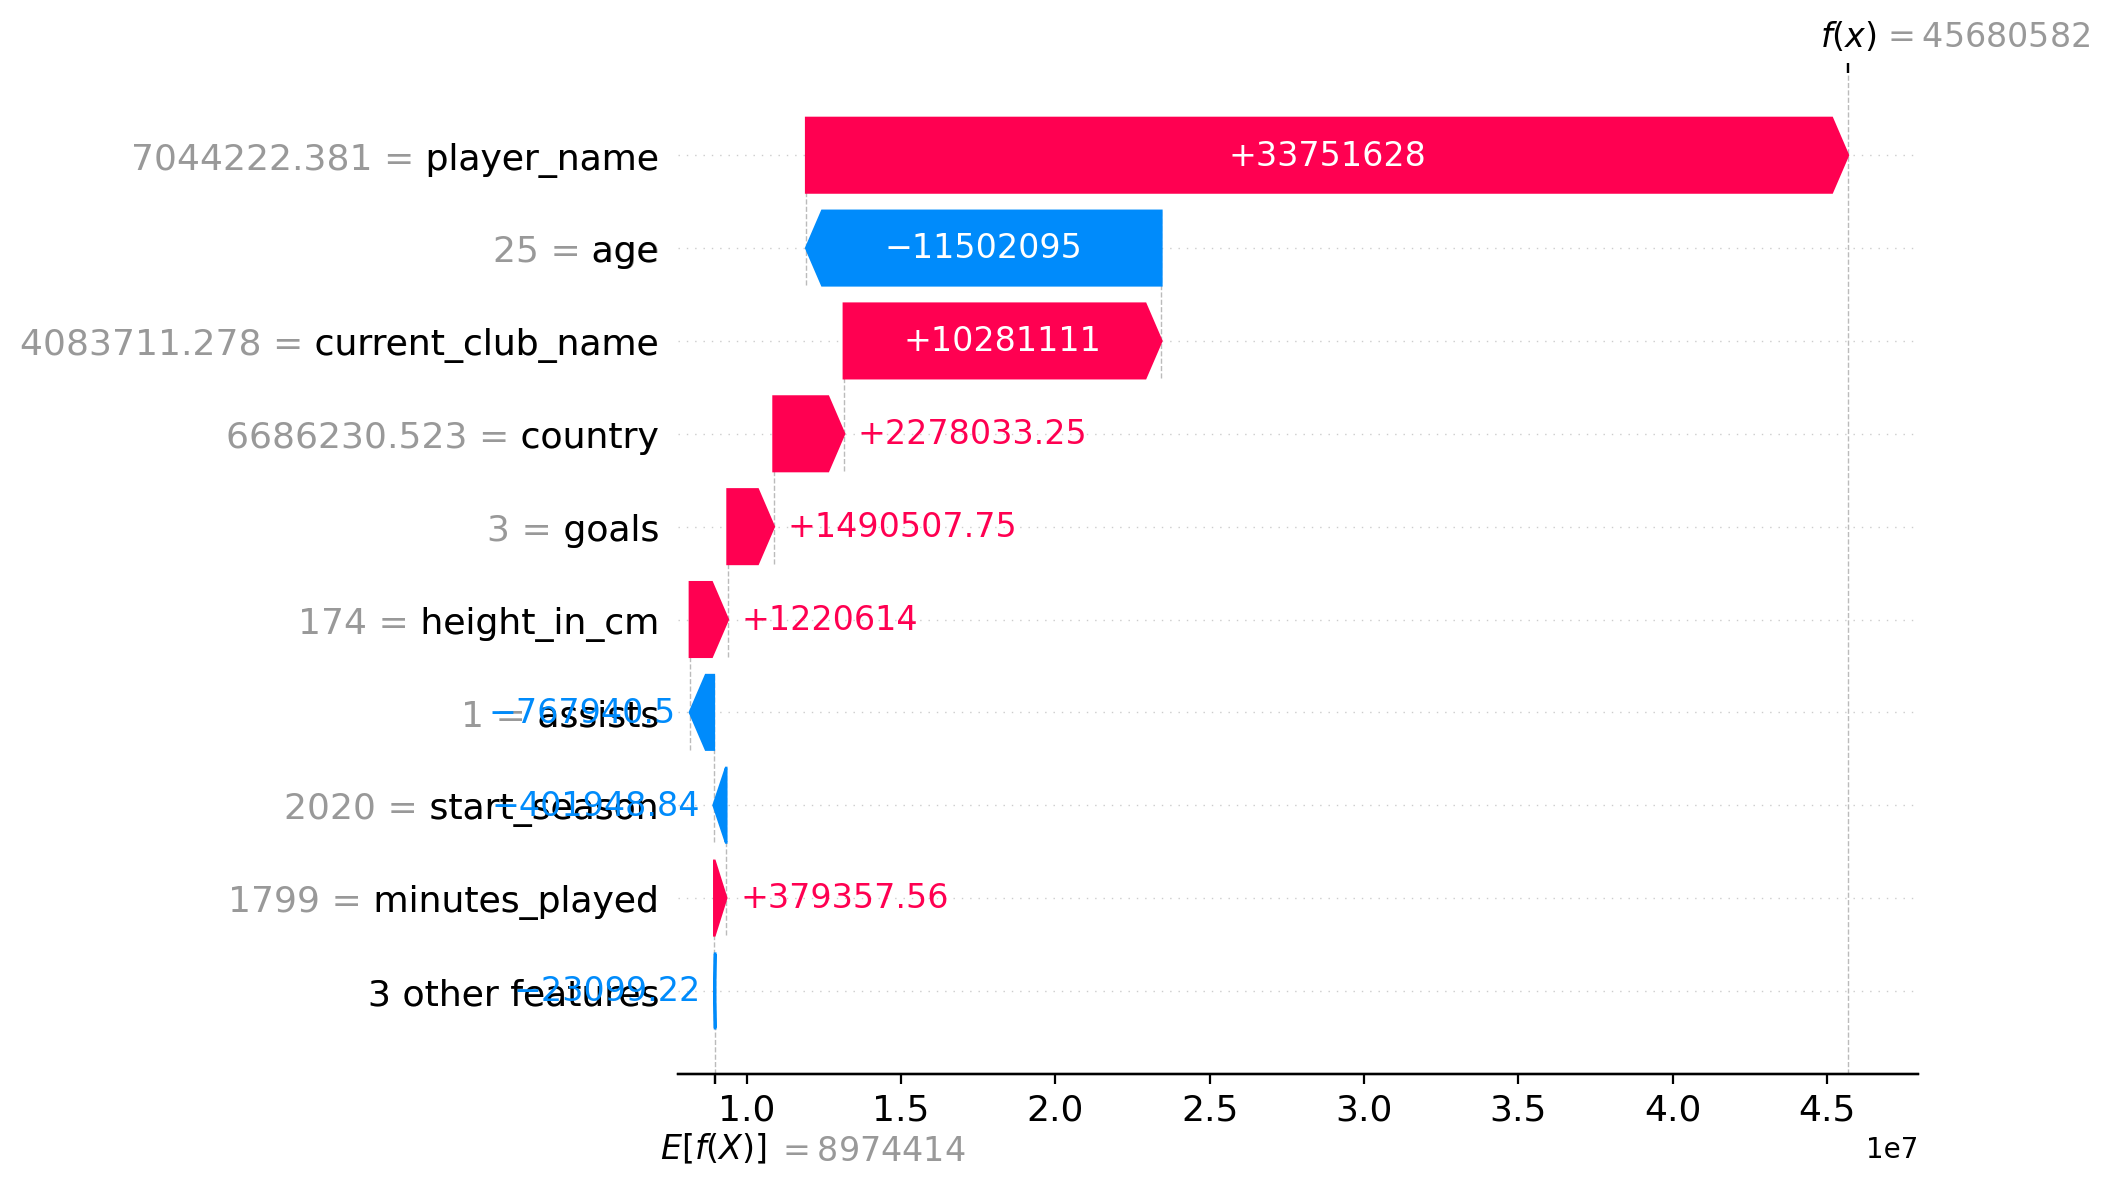

In [139]:
shap.plots.waterfall(shap_values[0])